In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from statsmodels.tsa.arima.model import ARIMA

# --- Load datasets ---
train_file_path = "/content/drive/MyDrive/final_project/Train/Train_Daily activity metrics.csv"
test_file_path = "/content/drive/MyDrive/final_project/Test/Test_Daily activity metrics.csv"
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# --- Standardize column names ---
df_train.columns = df_train.columns.str.strip().str.lower().str.replace(' ', '_')
df_test.columns = df_test.columns.str.strip().str.lower().str.replace(' ', '_')

# --- Clean numeric columns ---
def clean_numeric_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = (df[col].astype(str)
                   .apply(lambda x: re.sub(r'[^0-9.]', '', x)))
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

df_train = clean_numeric_columns(df_train)
df_test = clean_numeric_columns(df_test)

df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

# --- Feature Engineering ---
# Intensity = step_count * average_heart_rate
for df in [df_train, df_test]:
    df['intensity'] = df['step_count'].fillna(5000) * df['average_heart_rate_(bpm)'].fillna(75)

# --- Health Risk Classification ---
def classify_health_risk(df):
    step_threshold = np.percentile(df['step_count'].dropna(), 10)
    risk_score = (
        (df['step_count'].fillna(5000) < step_threshold).astype(int) +
        (df['average_heart_rate_(bpm)'].fillna(75) > 100).astype(int) +
        (df['average_heart_rate_(bpm)'].fillna(75) < 50).astype(int)
    )
    if 'average_body_temperature_(°c)' in df.columns:
        risk_score += (df['average_body_temperature_(°c)'].fillna(37) > 38).astype(int)
    return (risk_score >= 2).astype(int)

df_train['risk'] = classify_health_risk(df_train)
df_test['risk'] = classify_health_risk(df_test)

# --- ARIMA Forecast for Future Step Count ---
step_series = df_train['step_count'].dropna()
if len(step_series) > 5:
    arima_model = ARIMA(step_series, order=(5,1,0))
    arima_fit = arima_model.fit()
    future_steps = arima_fit.forecast(steps=7)
else:
    future_steps = None

# --- Calories Burned Estimation ---
for df in [df_train, df_test]:
    df['calories_burned'] = df['step_count'].fillna(5000) * 0.04 + \
                             df['average_heart_rate_(bpm)'].fillna(75) * 0.03

# --- Lifestyle Category ---
def classify_lifestyle(step_count):
    if step_count > 8000:
        return 'Active'
    elif step_count > 5000:
        return 'Moderate'
    return 'Sedentary'

df_test['lifestyle_category'] = df_test['step_count'].apply(classify_lifestyle)

# --- Additional Predictions ---
def predict_sleep_quality(df):
    sleep_score = (df['step_count'].fillna(5000) / 1000) + \
                  ((100 - df['average_heart_rate_(bpm)'].fillna(75)) / 10)
    return np.where(sleep_score > 8, 'Good', 'Poor')

def predict_stress(df):
    return np.where(df['average_heart_rate_(bpm)'].fillna(75) > 80, 'High', 'Normal')

def estimate_hydration(df):
    base = 2.0
    extra = (df['step_count'].fillna(5000) / 5000) * 0.5
    if 'average_body_temperature_(°c)' in df.columns:
        extra += (df['average_body_temperature_(°c)'].fillna(37) - 37) * 0.2
    return base + extra

def predict_recovery_time(df):
    return np.where(df['intensity'] > 500000, '48 hours',
                  np.where(df['intensity'] > 300000, '24 hours', '<12 hours'))

def estimate_metabolic_age(df):
    age = 40 - (df['step_count'].fillna(5000) / 1000) + \
          (df['average_heart_rate_(bpm)'].fillna(75) - 70) / 2
    return np.clip(age, 20, 70).astype(int)

def estimate_vo2_max(df):
    return 50 - (df['average_heart_rate_(bpm)'].fillna(75) / 5) + \
           (df['step_count'].fillna(5000) / 2000)

def productivity_score(df):
    morning = df['step_count'].fillna(5000) * 0.4
    return np.where(morning > 3000, 'High',
                  np.where(morning > 1500, 'Medium', 'Low'))

# Apply additional predictors
df_test['sleep_quality'] = predict_sleep_quality(df_test)
df_test['stress_level'] = predict_stress(df_test)
df_test['recommended_water_intake_(l)'] = estimate_hydration(df_test)
df_test['recovery_time'] = predict_recovery_time(df_test)
df_test['estimated_metabolic_age'] = estimate_metabolic_age(df_test)
df_test['estimated_vo2_max'] = estimate_vo2_max(df_test)
df_test['productivity_score'] = productivity_score(df_test)

# --- Add Steps to Increase ---
df_test['steps_to_increase'] = df_test['step_count'].apply(lambda x: max(8000 - x, 0))

# --- Fitness Recommendation Generator ---
def fitness_recommendation(lifestyle, risk):
    if risk == 1:
        return (
            "**Increase Physical Activity:** Aim for 150+ mins of moderate exercise per week (brisk walking, cycling).\n"
            "Strength training 2x/week to improve metabolism. Start small: short walks, use stairs.\n"
            "**Improve Diet:** Reduce processed sugars, refined carbs, unhealthy fats. Increase fiber, lean proteins, and healthy fats.\n"
            "**Health Monitoring:** Check blood pressure, sugar, cholesterol regularly; consult doctor.\n"
            "**Lifestyle Adjustments:** Break long sitting periods; prioritize sleep (7-9 hrs) and stress management."
        )
    return (
        "**Sustain Physical Activity:** 150+ mins moderate or 75 mins vigorous exercise weekly.\n"
        "Strength training 2x/week to preserve muscle.\n"
        "**Optimize Nutrition:** Whole foods; stay hydrated; limit processed sugars.\n"
        "**Preventative Health:** Annual check-ups; monitor sleep and stress.\n"
        "**Next-Level Fitness:** Zone 2 cardio, HIIT, mobility work."
    )

df_test['fitness_recommendation'] = df_test.apply(
    lambda r: fitness_recommendation(r['lifestyle_category'], r['risk']), axis=1
)

# --- Train Health Risk Classifier ---
features = ['step_count', 'average_heart_rate_(bpm)', 'calories_burned', 'intensity']
X = df_train[features]
y = df_train['risk']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# --- Output Results ---
def print_test_results(df):
    for idx, row in df.iterrows():
        print(f"Test Sample {idx + 1}:")
        print(f"Current Step Count: {row['step_count']}")
        print(f"Predicted Calories Burned: {row['calories_burned']:.2f}")
        print(f"Steps to Increase: {int(row['steps_to_increase'])}")
        print(f"Predicted Health Risk: {'High' if row['risk'] == 1 else 'Low'}")
        print(f"Lifestyle Category: {row['lifestyle_category']}")
        print(f"Fitness Recommendation: {row['fitness_recommendation']}\n")
        print('-' * 80)

print_test_results(df_test)

print("Predicted Step Count for Next 7 Days:")
print(future_steps)



Test Sample 1:
Current Step Count: 742.0
Predicted Calories Burned: 32.47
Steps to Increase: 7258
Predicted Health Risk: High
Lifestyle Category: Sedentary
Fitness Recommendation: **Increase Physical Activity:** Aim for 150+ mins of moderate exercise per week (brisk walking, cycling).
Strength training 2x/week to improve metabolism. Start small: short walks, use stairs.
**Improve Diet:** Reduce processed sugars, refined carbs, unhealthy fats. Increase fiber, lean proteins, and healthy fats.
**Health Monitoring:** Check blood pressure, sugar, cholesterol regularly; consult doctor.
**Lifestyle Adjustments:** Break long sitting periods; prioritize sleep (7-9 hrs) and stress management.

--------------------------------------------------------------------------------
Test Sample 2:
Current Step Count: 2975.0
Predicted Calories Burned: 121.79
Steps to Increase: 5025
Predicted Health Risk: Low
Lifestyle Category: Sedentary
Fitness Recommendation: **Sustain Physical Activity:** 150+ mins mode

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


NameError: name 'X_test' is not defined

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:12:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


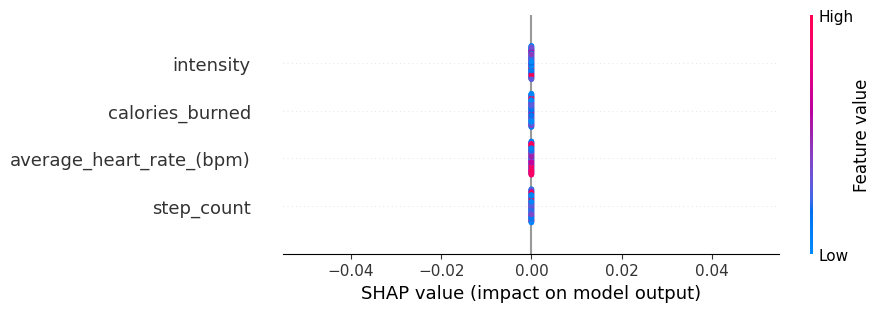

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from statsmodels.tsa.arima.model import ARIMA
import shap

# Load datasets
train_file_path = "/content/drive/MyDrive/final_project/Train/Train_Daily activity metrics.csv"
test_file_path = "/content/drive/MyDrive/final_project/Test/Test_Daily activity metrics.csv"
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Clean column names
df_train.columns = df_train.columns.str.strip().str.lower().str.replace(' ', '_')
df_test.columns = df_test.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean numeric columns
def clean_numeric_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^0-9.]', '', x))
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

df_train = clean_numeric_columns(df_train)
df_test = clean_numeric_columns(df_test)

# Fill missing values
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

# Feature Engineering
df_train["intensity"] = df_train["step_count"].fillna(5000) * df_train["average_heart_rate_(bpm)"].fillna(75)
df_test["intensity"] = df_test["step_count"].fillna(5000) * df_test["average_heart_rate_(bpm)"].fillna(75)

# Health Risk Classification
def classify_health_risk(df):
    step_threshold = np.percentile(df["step_count"].dropna(), 10)
    risk_score = (
        (df["step_count"].fillna(5000) < step_threshold).astype(int) +
        (df["average_heart_rate_(bpm)"].fillna(75) > 100).astype(int) +
        (df["average_heart_rate_(bpm)"].fillna(75) < 50).astype(int)
    )
    if "average_body_temperature_(°c)" in df.columns:
        risk_score += (df["average_body_temperature_(°c)"].fillna(37) > 38).astype(int)
    return (risk_score >= 2).astype(int)

df_train["risk"] = classify_health_risk(df_train)
df_test["risk"] = classify_health_risk(df_test)

# ARIMA step forecast
step_series = df_train["step_count"].dropna()
if len(step_series) > 5:
    model = ARIMA(step_series, order=(5,1,0))
    model_fit = model.fit()
    future_steps = model_fit.forecast(steps=7)
else:
    future_steps = "Not enough data for ARIMA"

# Calories burned
df_train["calories_burned"] = df_train["step_count"].fillna(5000) * 0.04 + df_train["average_heart_rate_(bpm)"].fillna(75) * 0.03
df_test["calories_burned"] = df_test["step_count"].fillna(5000) * 0.04 + df_test["average_heart_rate_(bpm)"].fillna(75) * 0.03

# Lifestyle category
def classify_lifestyle(step_count):
    if step_count > 8000:
        return "Active"
    elif step_count > 5000:
        return "Moderate"
    else:
        return "Sedentary"

df_test["lifestyle_category"] = df_test["step_count"].apply(classify_lifestyle)

# Sleep quality
def predict_sleep_quality(df):
    sleep_score = (df["step_count"].fillna(5000) / 1000) + ((100 - df["average_heart_rate_(bpm)"].fillna(75)) / 10)
    return np.where(sleep_score > 8, "Good", "Poor")

df_test["sleep_quality"] = predict_sleep_quality(df_test)

# Stress level
df_test["stress_level"] = np.where(df_test["average_heart_rate_(bpm)"].fillna(75) > 80, "High", "Normal")

# Hydration
def estimate_hydration(df):
    base_water = 2.0
    additional_water = (df["step_count"].fillna(5000) / 5000) * 0.5
    if "average_body_temperature_(°c)" in df.columns:
        additional_water += (df["average_body_temperature_(°c)"].fillna(37) - 37) * 0.2
    return base_water + additional_water

df_test["recommended_water_intake_(l)"] = estimate_hydration(df_test)

# Recovery time
def predict_recovery_time(df):
    return np.where(df["intensity"] > 500000, "48 hours",
           np.where(df["intensity"] > 300000, "24 hours", "<12 hours"))

df_test["recovery_time"] = predict_recovery_time(df_test)

# Metabolic age
def estimate_metabolic_age(df):
    metabolic_age = 40 - (df["step_count"].fillna(5000) / 1000) + (df["average_heart_rate_(bpm)"].fillna(75) - 70) / 2
    return np.clip(metabolic_age, 20, 70).astype(int)

df_test["estimated_metabolic_age"] = estimate_metabolic_age(df_test)

# VO2 max
def estimate_vo2_max(df):
    return 50 - (df["average_heart_rate_(bpm)"].fillna(75) / 5) + (df["step_count"].fillna(5000) / 2000)

df_test["estimated_vo2_max"] = estimate_vo2_max(df_test)

# Productivity score
def productivity_score(df):
    morning_steps = df["step_count"].fillna(5000) * 0.4
    return np.where(morning_steps > 3000, "High", np.where(morning_steps > 1500, "Medium", "Low"))

df_test["productivity_score"] = productivity_score(df_test)

# Weekly trend
def weekly_trend(steps):
    if len(steps) < 7:
        return "Insufficient data"
    slope = np.polyfit(range(7), steps[-7:], 1)[0]
    if slope > 5:
        return "Increasing"
    elif slope < -5:
        return "Decreasing"
    else:
        return "Stable"

if len(df_train) >= 7:
    df_test["weekly_activity_trend"] = weekly_trend(df_train["step_count"].values)
else:
    df_test["weekly_activity_trend"] = "Insufficient data"

# Fitness recommendation
def fitness_recommendation(lifestyle, risk):
    if risk == 1:
        return "Increase Physical Activity: Aim for 150+ mins/week. Improve Diet. Monitor health and stress."
    else:
        return "Maintain Activity: 150+ mins/week. Balanced Diet. Monitor sleep/stress. Optional: Zone 2 or HIIT."

df_test["fitness_recommendation"] = df_test.apply(lambda row: fitness_recommendation(row["lifestyle_category"], row["risk"]), axis=1)

# ---- Model Training for Health Risk Classification ----
features = ["step_count", "average_heart_rate_(bpm)", "calories_burned", "intensity"]
X = df_train[features]
y = df_train["risk"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# ---- SHAP Explainability (Safe Version with Sampling) ----
sample_X = X_train.sample(n=100, random_state=42)
explainer = shap.Explainer(clf, sample_X)
shap_values = explainer(sample_X)

# Visualize SHAP summary (beeswarm) plot
shap.initjs()
shap.plots.beeswarm(shap_values)




In [ ]:
# Install the SHAP JupyterLab extension
!pip install shap
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel
kernelspec migrate nbclassic nbconvert nbextension notebook run server
serverextension troubleshoot trust

Jupyter command `jupyter-labextension` not found.



Feature Importances:
step_count: 0.0000
average_heart_rate_(bpm): 0.0000
calories_burned: 0.0000
intensity: 0.0000

Feature Correlation Matrix:
                          step_count  average_heart_rate_(bpm)  \
step_count                  1.000000                 -0.014468   
average_heart_rate_(bpm)   -0.014468                  1.000000   
calories_burned             0.999998                 -0.012467   
intensity                   0.977729                  0.131820   

                          calories_burned  intensity  
step_count                       0.999998   0.977729  
average_heart_rate_(bpm)        -0.012467   0.131820  
calories_burned                  1.000000   0.978019  
intensity                        0.978019   1.000000  

Generating SHAP Summary Plot...


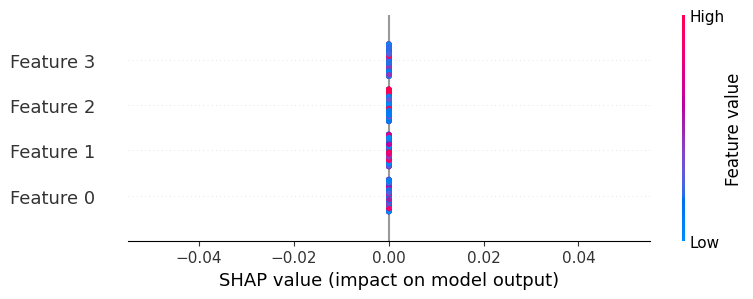


SHAP Force Plot for First Test Sample (Binary Classification):


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
import pandas as pd

# --- Check Random Forest Feature Importance ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

feature_importance = rf_clf.feature_importances_
feature_importance_dict = dict(zip(X_train.columns, feature_importance))
print("\nFeature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.4f}")

# --- Check Feature Correlation Matrix ---
correlation_matrix = X_train.corr()
print("\nFeature Correlation Matrix:")
print(correlation_matrix)

# --- Scaling the Data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- Re-train Random Forest with Scaled Data ---
rf_clf.fit(X_train_scaled, y_train)

# --- SHAP Explanation ---
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_val_scaled)

# --- SHAP Summary Plot ---
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_val_scaled)

# --- Optional: SHAP Force Plot for First Instance ---
shap.initjs()

# Check if there's only one class predicted
if len(shap_values) == 1:
    # For binary classification, if only one class is present, use shap_values[0] for the only class
    print("\nSHAP Force Plot for First Test Sample (Single Class Prediction):")
    shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val.iloc[0])
else:
    # For binary classification, use shap_values[1] for the positive class
    print("\nSHAP Force Plot for First Test Sample (Binary Classification):")


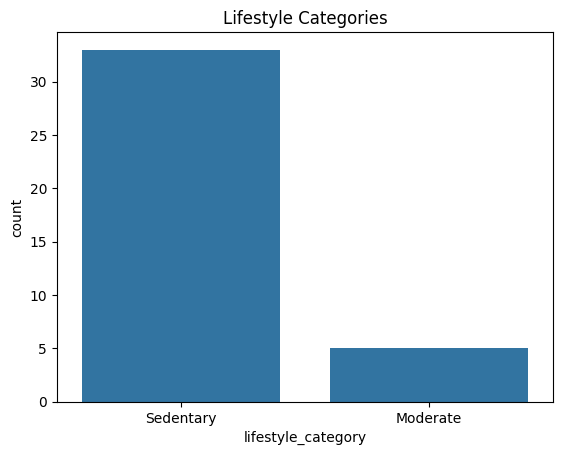

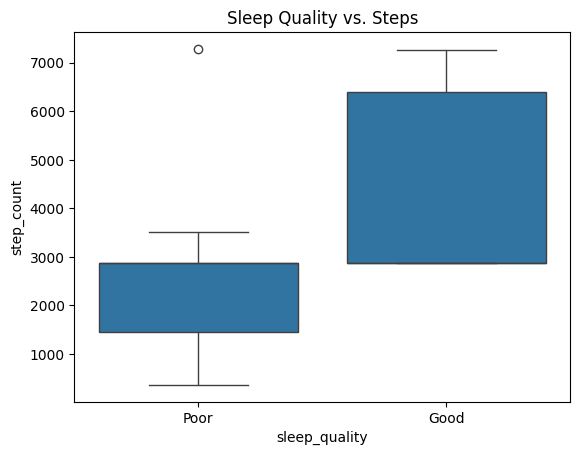

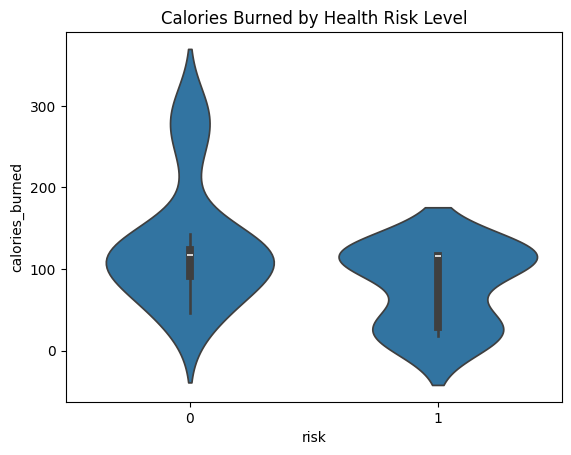

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lifestyle Category Distribution
sns.countplot(x='lifestyle_category', data=df_test)
plt.title("Lifestyle Categories")
plt.show()

# Sleep Quality vs. Step Count
sns.boxplot(x='sleep_quality', y='step_count', data=df_test)
plt.title("Sleep Quality vs. Steps")
plt.show()

# Risk vs. Calories Burned
sns.violinplot(x='risk', y='calories_burned', data=df_test)
plt.title("Calories Burned by Health Risk Level")
plt.show()
